### NLP Project

### Importing Dependencies

In [1]:
# Importing dependencies
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import re
import string
from nltk.stem import PorterStemmer
import nltk
# nltk.download()
from sklearn import *
import bz2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
# !pip install spacy
import spacy
# !pip install en_core_web_sm
import en_core_web_sm 
nlp = en_core_web_sm.load()
# from nltk.stem import SnowballStemmer
from timeit import default_timer as timer
from sklearn import naive_bayes
from wordcloud import WordCloud
from flask import Flask
import pickle
import unicodedata
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'spacy'

### Extracting Dataset

In [4]:
# Reading Dataset
def extract(file):
    target = []
    feature = []
    for line in bz2.BZ2File(file):
        text = line.decode('utf-8')
        target.append(text[9])
        feature.append(text[10:].strip())
    return np.array(target), feature

print("Extracting dataset..............")
train_label, train_text = extract('train.ft.txt.bz2')
test_label, test_text = extract('test.ft.txt.bz2')
print('Done........')

Extracting dataset..............
Done........


In [5]:
print('Total size of dataset:', len(train_text) + len(test_text))

Total size of dataset: 4000000


### Data Preparation

In [202]:
# en = spacy.load('en_core_web_sm')
# sw_spacy = en.Defaults.stop_words
lemmatizer = WordNetLemmatizer()

def normalize_text(file):
    normalized_text = []
    table = str.maketrans ("","", string.punctuation) #remove punctuation from string
    for i in file:
        text = i.translate(table)
        text = text.lower() # Converting text to lowercase
        text = re.sub('\w*\d\w*', '', text) #remove numbers  
        text = text.split() # Splitting the sentence into words
        text = [i for i in text if len(i) > 2] # dropping all words that are not up to 2 letters
        text = [lemmatizer.lemmatize(w) for w in text if not w in sw_spacy] # Lemmatizing and applying stopwords to the text
        text = ' '.join(text)
        
        normalized_text.append(text)
    return normalized_text

In [203]:
train_texts = normalize_text(train_text[:20000])

In [204]:
print("This is the original product review: \n \n", train_text[13])

This is the original product review: 
 
 Oh please: I guess you have to be a romance novel lover for this one, and not a very discerning one. All others beware! It is absolute drivel. I figured I was in trouble when a typo is prominently featured on the back cover, but the first page of the book removed all doubt. Wait - maybe I'm missing the point. A quick re-read of the beginning now makes it clear. This has to be an intentional churning of over-heated prose for satiric purposes. Phew, so glad I didn't waste $10.95 after all.


In [205]:
print("This is the processed product review: \n \n", train_texts[13])

This is the processed product review: 
 
 guess romance novel lover discerning beware absolute drivel figured trouble typo prominently featured cover page book removed doubt wait maybe missing point quick reread beginning make clear intentional churning overheated prose satiric purpose phew glad didnt waste


In [206]:
print("Original text length: ", len(train_text[1999]))
print("processed text length: ", len(train_texts[1999]))

Original text length:  394
processed text length:  226


In [207]:
len(train_texts)

20000

- Converting text data to numerical data.

In [208]:
training_text = train_texts
cv = CountVectorizer(ngram_range=(1, 4))
cv.fit(training_text)
print("Word size: {}".format(len(cv.vocabulary_)))

Word size: 1790581


In [209]:
BOW = cv.transform(training_text)
BOW

<20000x1790581 sparse matrix of type '<class 'numpy.int64'>'
	with 2533817 stored elements in Compressed Sparse Row format>

In [210]:
y_train = train_label[:20000]

In [211]:
X_train_raw = BOW
X_train_raw

<20000x1790581 sparse matrix of type '<class 'numpy.int64'>'
	with 2533817 stored elements in Compressed Sparse Row format>

### Data Splitting

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train, test_size = 0.20)

# Print shapes and bounds
print('Train set:')
print('Sizes:', X_train.shape, y_train.shape)  

print('Test set:')
print('Sizes:', X_test.shape, y_test.shape)


Train set:
Sizes: (16000, 1790581) (16000,)
Test set:
Sizes: (4000, 1790581) (4000,)


Total label frequency: 
 [['1' '2']
 ['9743' '10257']]


<AxesSubplot:>

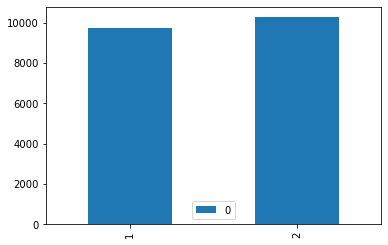

In [213]:
train_labels, train_labels_count = np.unique(y_train, return_counts=True)
test_labels, test_labels_count = np.unique(y_test, return_counts=True)
label_count = train_labels_count + test_labels_count
print("Total label frequency: \n", np.asarray((train_labels, label_count)))
label_df = pd.DataFrame(label_count, train_labels)
label_df.transpose()
label_df.plot.bar()

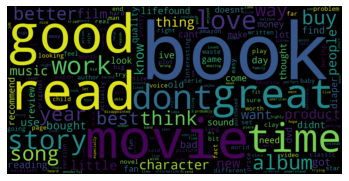

In [214]:
word_cloud = WordCloud(collocations = False, background_color = 'black', width = 2000, height = 1000).generate(''.join(train_texts))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Building and Training Data.

### Logistic Regression

In [215]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [0.1, 100]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.858021 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [198]:
lr = LogisticRegression(random_state=0, solver = 'liblinear', penalty = 'l2', C = 100, max_iter = 1000)

In [199]:
#measuring time it takes to fit model
start = timer()
lr_pickle = lr.fit(X_train, y_train)
end = timer()
print("model fit time in seconds: ", end - start)

model fit time in seconds:  8.84623881499283


In [200]:
#measuring time it takes to predict
start = timer()
X_lr_pred = lr.predict(X_test)
end = timer()
print("model prediction time in seconds: ", end - start)

model prediction time in seconds:  0.069516000978183


In [201]:
print("Confusion_matrix: \n \n", confusion_matrix(y_test, X_lr_pred), '\n')
print("Accuracy score for logistic regression model: ", accuracy_score(y_test, X_lr_pred), '\n')
print(classification_report(y_test, X_lr_pred))

Confusion_matrix: 
 
 [[1713  261]
 [ 198 1828]] 

Accuracy score for logistic regression model:  0.88525 

              precision    recall  f1-score   support

           1       0.90      0.87      0.88      1974
           2       0.88      0.90      0.89      2026

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



### SVM Model

In [136]:
svm = SVC(C=3,kernel = 'rbf', random_state = 0)

In [137]:
#measuring time it takes to fit model
start = timer()
svm.fit(X_train, y_train)
end = timer()
print(end - start)

711.0335148599988


In [138]:
#measuring time it takes to fit model
start = timer()
X_svm_pred = svm.predict(X_test)
end = timer()
print(end - start)

59.53519562899601


In [139]:
print("SVM Confusion_matrix: \n \n", confusion_matrix(y_test, X_svm_pred), '\n')
print("SVM Accuracy score model: ", accuracy_score(y_test, X_svm_pred), '\n')
print(classification_report(y_test, X_svm_pred))

SVM Confusion_matrix: 
 
 [[1678  263]
 [ 284 1775]] 

SVM Accuracy score model:  0.86325 

              precision    recall  f1-score   support

           1       0.86      0.86      0.86      1941
           2       0.87      0.86      0.87      2059

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



Some thing i am working on

### Naive Bayes

In [163]:
NB = naive_bayes.MultinomialNB()

#measuring time it takes to fit model
start = timer()
NB.fit(X_train, y_train)
end = timer()
print(end - start)

0.2060097870125901


In [164]:
#measuring time it takes to fit model
start = timer()
X_cl_pred = NB.predict(X_test)
end = timer()
print(end - start)

0.03920892800670117


In [165]:
print("Naive Bayes Confusion_matrix: \n \n", confusion_matrix(y_test, X_cl_pred), '\n')
print("Naive Bayes Accuracy score model: ", accuracy_score(y_test, X_cl_pred), '\n')
print(classification_report(y_test, X_cl_pred))

Naive Bayes Confusion_matrix: 
 
 [[1756  218]
 [ 274 1752]] 

Naive Bayes Accuracy score model:  0.877 

              precision    recall  f1-score   support

           1       0.87      0.89      0.88      1974
           2       0.89      0.86      0.88      2026

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



In [143]:
text = "This book is not so bad"

In [144]:
pickle.dump(lr_pickle, open('sent.pkl', 'wb'))

In [145]:
test_np = ["This book is not so bad"]
test = cv.transform(test_np)

In [146]:
model = pickle.load(open('sent.pkl', 'rb'))
model.predict(test)

array(['1'], dtype='<U1')

In [101]:
text = normalize_text(test_np)

In [102]:
print(text)

['book bad']


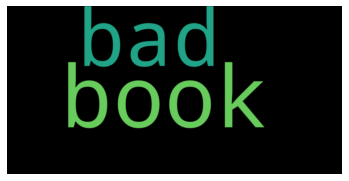

In [95]:
word_cloud = WordCloud(collocations = False, background_color = 'black', width = 2000, height = 1000).generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()